In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")

from src.masked.kernel import TSGaussKernel,TSGaussGaussKernel
from src.masked.loss import VarifoldLoss
from src.masked.lddmm import Shooting,Flowing
from src.plotting import plot2Dfigure

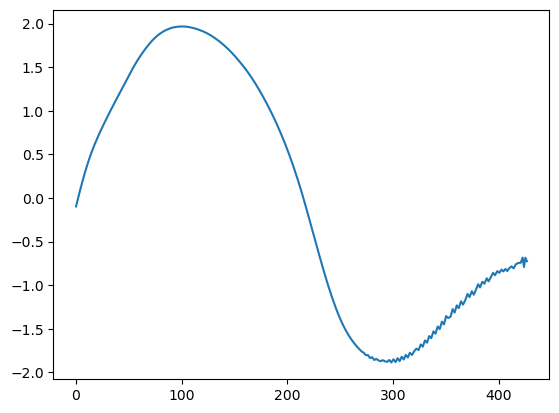

In [2]:
np.random.seed(0)

y =pd.read_csv("./dataset/y.csv",index_col=0)
X = np.load("./dataset/X.npy")
X_mask = np.load("./dataset/X_mask.npy")
idxs = np.load("./results/exp_1_lddmm_1/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/exp_1_lddmm_1/p0s.npy")
q0 = np.load("./results/exp_1_lddmm_1/q0.npy")
q0_mask = np.load("./results/exp_1_lddmm_1/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(*q0[q0_mask.squeeze(),:].T)

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

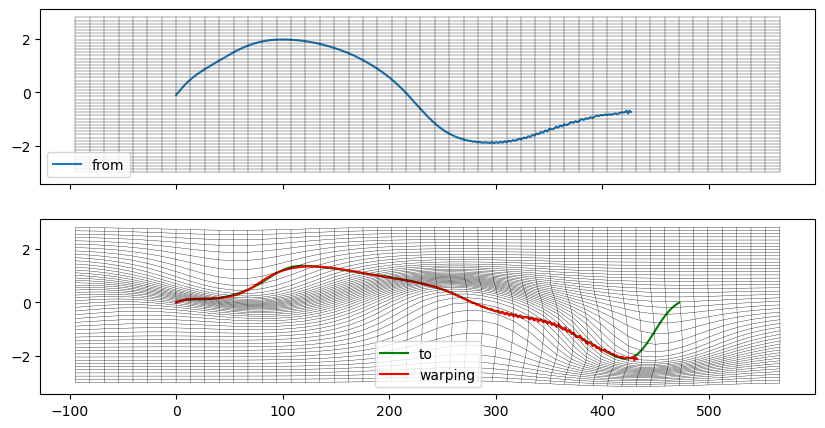

In [3]:
Kv = TSGaussKernel(100,1)
Kl = TSGaussGaussKernel(2,1,2,0.6)
dataloss = VarifoldLoss(Kl)

shoot = Shooting(Kv)
flow = Flowing(Kv)

plot2Dfigure(q0,X[0],p0s[0],shoot,flow,q0_mask,X_mask[0])

2024-03-28 14:30:35.775835: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.10 = f32[1000,1000]{1,0} reduce(f32[1000,1000,2]{2,1,0} %constant.3, f32[] %constant.5), dimensions={2}, to_apply=%region_0.6, metadata={op_name="jit(<lambda>)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/germain/code/shape-time/mouse/../src/masked/kernel.py" source_line=18}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-28 14:30:36.598910: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.823201336s
Constant folding an instruction is taking > 1s:

  %reduce

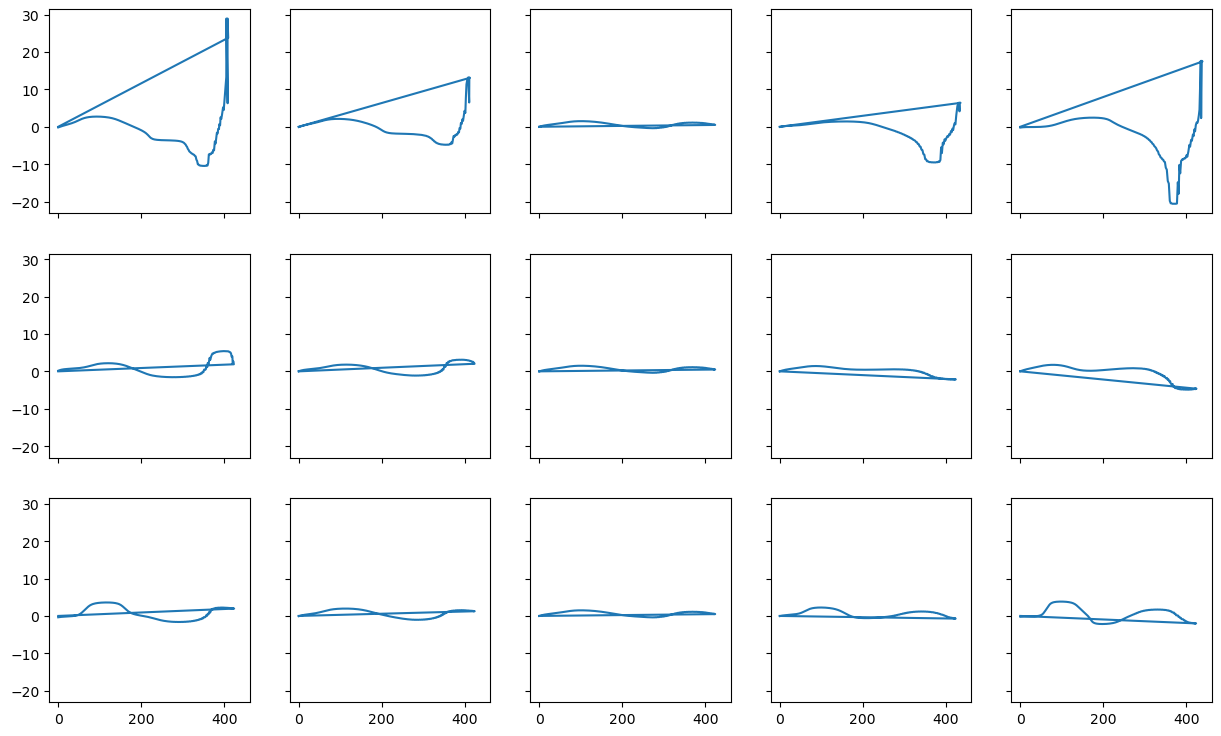

In [4]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,5
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*3,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for alpha in np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(*q.T)
        k += 1
plt.show()

In [5]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(ncomp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
df

,filename,genotype,before,start,end,mouse_id,PC1,PC2,PC3,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,colq_1,9.338976,-1.187416,0.393660,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,colq_1,-2.505247,3.079527,0.833243,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,colq_1,-7.708540,-0.199618,0.183294,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,colq_1,-1.593287,2.163067,1.391958,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,colq_1,-6.333896,6.514814,-0.863140,17.832642
...,...,...,...,...,...,...,...,...,...,...
12306,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,752806,753097,wt_7,-20.899494,-0.753441,-0.286070,6.273383
12266,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,298939,299250,wt_7,-16.366156,5.895099,3.306858,2.491158
12290,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,591395,591757,wt_7,-24.079861,-0.774130,-0.648077,4.928292
12427,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,2221605,2221865,wt_7,-19.278442,5.951013,2.929834,18.513375


In [6]:
import seaborn as sns

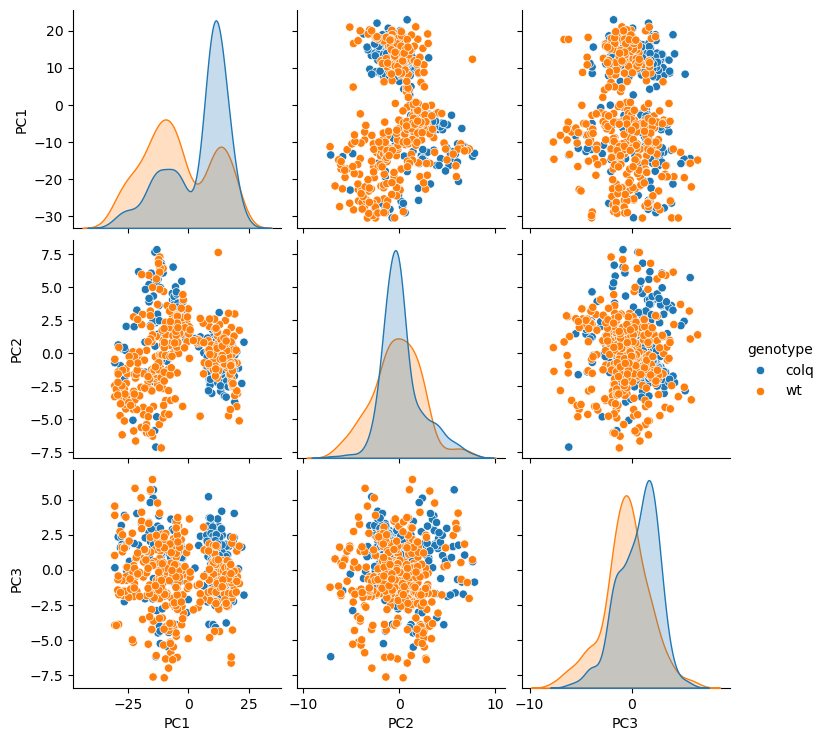

In [13]:
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(ncomp)])

In [8]:
tdf = df.copy()
filenames = tdf.filename.unique()

q_lst = []
q_mask_lst = []

for filename in filenames: 
    q = np.load("./results/exp_1_0/"+filename[:-4]+"_q0.npy")
    q_lst.append(q)
    q_mask = np.load("./results/exp_1_0/"+filename[:-4]+"_q0_mask.npy")
    q_mask_lst.append(q_mask)
        
qs = np.array(q_lst)
qs_mask = np.array(q_mask_lst)

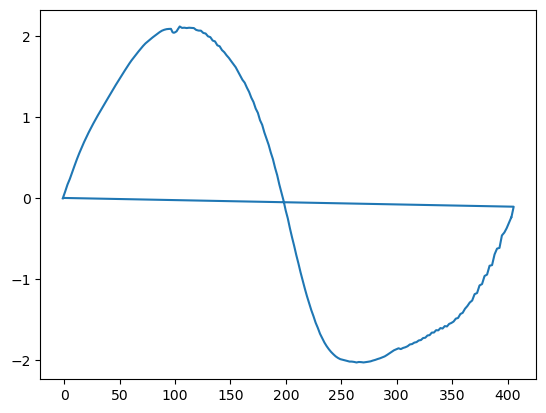

In [9]:
plt.plot(*qs[-3].T)

In [10]:
from src.masked.lddmm import batch_one_to_many_registration
from src.utils import batch_dataset
import optax
from optax.schedules import warmup_cosine_decay_schedule

In [11]:
bqs,bqs_mask = batch_dataset(qs,1,qs_mask)
schedule = warmup_cosine_decay_schedule(0,0.3,40,400,0)
optimizer = optax.adabelief(schedule)
bps,q0,q0_mask = batch_one_to_many_registration(q0,q0_mask,bqs,bqs_mask,Kv,dataloss,optimizer=optimizer,gamma_loss=1e-3,niter=400)

TypeError: dot_general requires contracting dimensions to have the same shape, got (600,) and (1000,).

In [ ]:
pcs =  mpca.transform(bps.squeeze())

In [ ]:
lst = []
for i,filename in enumerate(filenames): 
    tlst = [filename,mapping_dct[filename],*pcs[i].tolist()]
    lst.append(tlst)

In [ ]:
pdf = pd.DataFrame(lst,columns=["filename","mouse_id",*[f"PC{i+1}" for i in range(ncomp)]])
pdf["genotype"] = pdf["mouse_id"].apply(lambda x : x[:-2])
pdf.dtypes

filename     object
mouse_id     object
PC1         float64
PC2         float64
PC3         float64
genotype     object
dtype: object

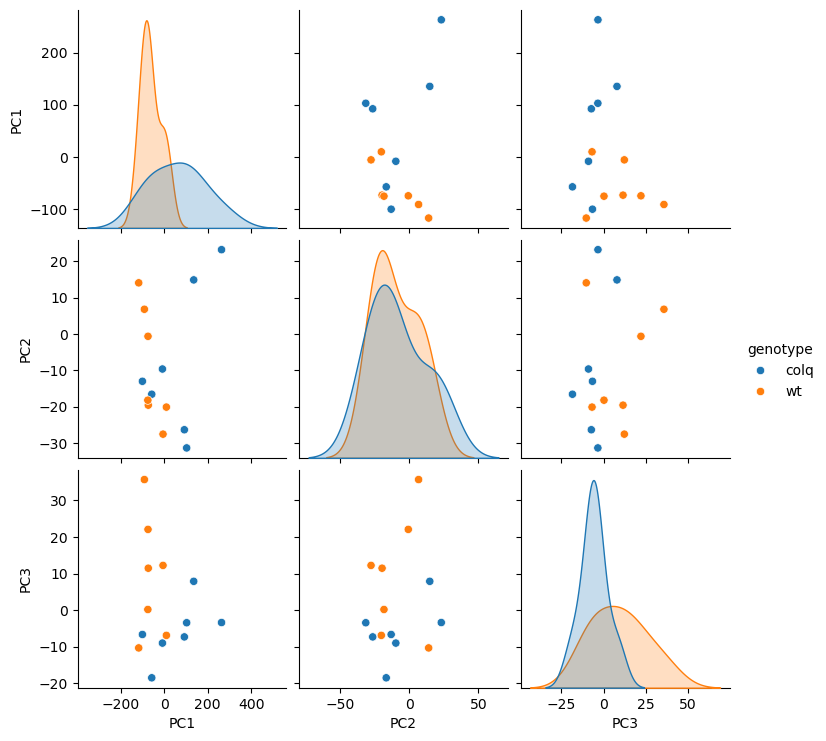

In [ ]:
p = sns.pairplot(pdf,hue = "genotype",vars=[f"PC{i+1}" for i in range(ncomp)])
#for line in pdf[["mouse_id",*[f"PC_{i}" for i in range(ncomp)]]].values:
#    for i in range(ncomp): 
#        for j in range(ncomp): 
#            if i != j: 
#                p.axes[i,j].annotate(" "+line[0],(line[j+1],line[i+1]),fontsize=8)


In [8]:
from scipy.stats import gaussian_kde

In [9]:
df

,filename,genotype,before,start,end,mouse_id,PC1,PC2,PC3,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,colq_1,9.338976,-1.187416,0.393660,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,colq_1,-2.505247,3.079527,0.833243,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,colq_1,-7.708540,-0.199618,0.183294,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,colq_1,-1.593287,2.163067,1.391958,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,colq_1,-6.333896,6.514814,-0.863140,17.832642
...,...,...,...,...,...,...,...,...,...,...
12306,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,752806,753097,wt_7,-20.899494,-0.753441,-0.286070,6.273383
12266,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,298939,299250,wt_7,-16.366156,5.895099,3.306858,2.491158
12290,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,591395,591757,wt_7,-24.079861,-0.774130,-0.648077,4.928292
12427,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,2221605,2221865,wt_7,-19.278442,5.951013,2.929834,18.513375


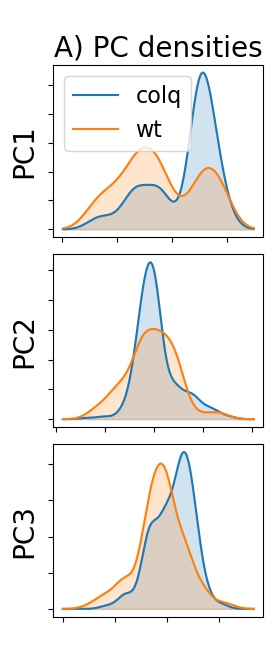

In [10]:
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(ncomp)]
span =0.3
nsample = 10000
ft_size = 20
pft_size = 16



fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3,ncomp*2.3))
for i,comp in enumerate(components): 
    r = df[comp].values.max()
    l = df[comp].values.min()
    x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
    for gen,color in color_mapping.items(): 
        arr = df[df.genotype == gen][comp].values
        y = gaussian_kde(arr)(x)
        axs[i].plot(x,y,color=color,label=gen)
        axs[i].fill_between(x,y,color=color,alpha=0.2)
        axs[i].set_ylabel(comp,fontsize=ft_size)


for ax in axs: 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
axs[0].legend(fontsize=pft_size)
axs[0].set_title("A) PC densities",fontsize=ft_size)
axs[-1].set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)


plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1__lddmm_density.jpeg",format="jpeg")

2024-03-28 14:32:57.244368: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %reduce.10 = f32[1000,1000]{1,0} reduce(f32[1000,1000,2]{2,1,0} %constant.3, f32[] %constant.5), dimensions={2}, to_apply=%region_0.6, metadata={op_name="jit(<lambda>)/jit(main)/reduce_sum[axes=(2,)]" source_file="/home/germain/code/shape-time/mouse/../src/masked/kernel.py" source_line=18}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-03-28 14:32:57.623421: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.37918878s
Constant folding an instruction is taking > 2s:

  %reduce.

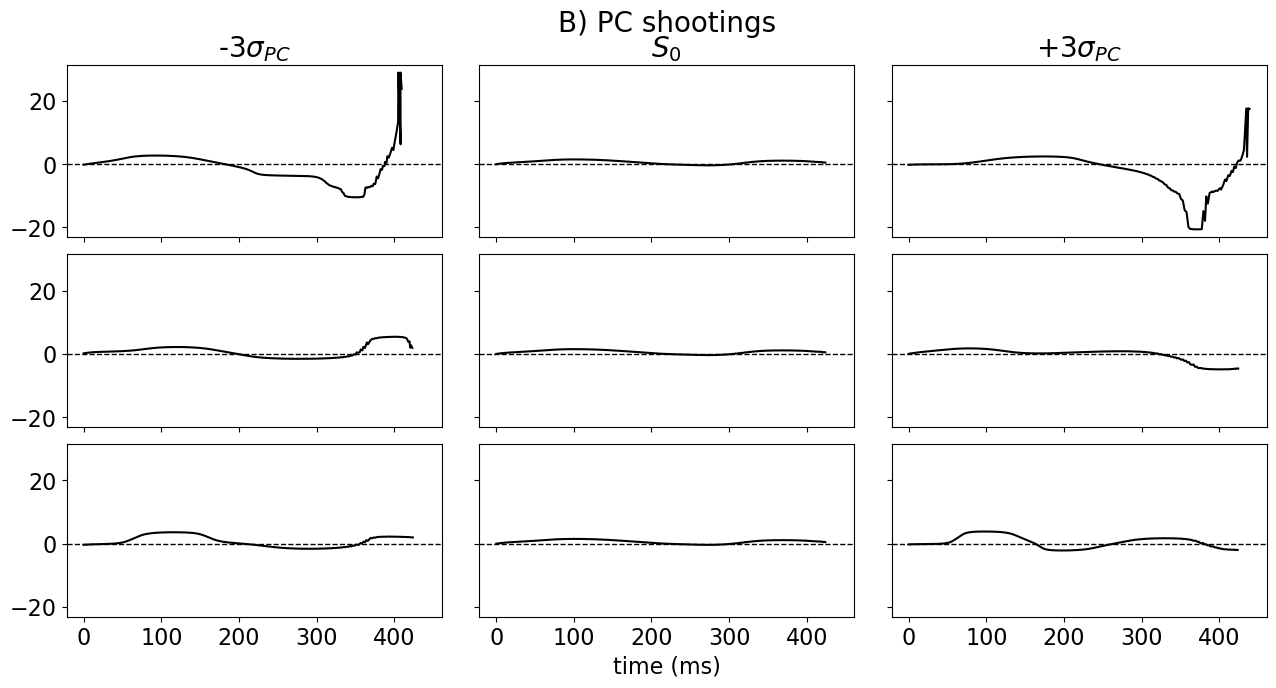

In [11]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,3
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*5,ncomp*2.3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for j,alpha in enumerate(np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp)):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        axs[pca_index,j].plot(*q[q0_mask.squeeze()].T,color="black")
        k += 1

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[-1,1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0,0].set_title(r"-3$\sigma_{PC}$",fontsize=ft_size)
axs[0,1].set_title(r"$S_0$",fontsize=ft_size)
axs[0,2].set_title(r"+3$\sigma_{PC}$",fontsize=ft_size)
for ax in axs[-1,:]:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs[:,0]:
    ax.yaxis.set_tick_params(labelsize=pft_size)

fig.suptitle("B) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1_lddmm_shooting.jpeg",format="jpeg")


In [12]:
idxs = np.argsort(pdf.PC1.values)[::-1]

NameError: name 'pdf' is not defined

In [ ]:
idxs

array([ 3256,  3408,  3345,  3336,  3415,  3420,  3243,  3384,  3250,
        3390,  3299,  3363,  3418,  3392,  3318,  3245,  3271,  3368,
        3275,  3312,  3421,  3383,  3283,  3397,  3298,  3361,  3417,
        3423,  3360,  3282,  3254,  3293,  3388,  3349,  3260,  3427,
        3367,  3242,  3321,  3344,  3372,  3304,  3264,  3351,  3406,
        3301,  3246,  3313,  3356,  3381,  3820,  3723,  3766,  3787,
        3784,  3714,  3762,  3772,  3801,  3785,  3815,  3745,  3790,
        3842,  3755,  3764,  3813,  3794,  3837,  3746,  3832,  3773,
        3734,  3828,  3786,  3728,  3760,  3722,  3826,  3808,  3804,
        3712,  3765,  3850,  3806,  3763,  3721,  3802,  3715,  3824,
        3727,  3768,  3835,  3791,  3767,  3803,  3829,  3856,  3823,
        3797,  4202,  4327,  4382,  4252,  4322,  4311,  4372,  4284,
        4265,  4213,  4207,  4336,  4331,  4376,  4225,  4240,  4290,
        4263,  4283,  4313,  4356,  4334,  4350,  4249,  4199,  4198,
        4333,  4326,

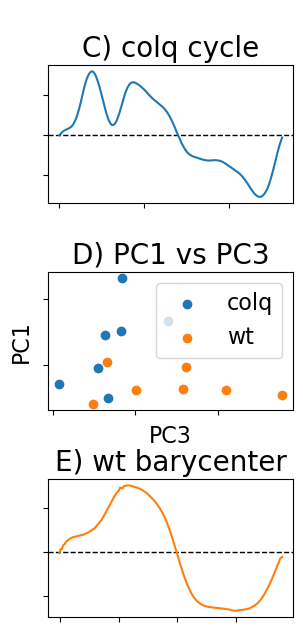

In [ ]:
fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3.5,ncomp*2.3))

idxs = np.argsort(df.PC1.values)[::-1]
idx = idxs[154]
q = X[idx]
q_mask = X_mask[idx]
axs[0].set_title("C) colq cycle",fontsize =ft_size)
axs[0].plot(*q[q_mask.squeeze()].T,color = color_mapping["colq"])
axs[0].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_title("D) PC1 vs PC3",fontsize =ft_size)
c = pdf[pdf.genotype == "colq"][["PC3","PC1"]].values
axs[1].scatter(*c.T,color=color_mapping["colq"],label="colq")
w = pdf[pdf.genotype == "wt"][["PC3","PC1"]].values
axs[1].scatter(*w.T,color = color_mapping["wt"],label="wt")
axs[1].set_xlabel("PC3", fontsize=pft_size)
axs[1].set_ylabel("PC1", fontsize=pft_size)

axs[2].set_title("E) wt barycenter",fontsize =ft_size)
idx = pdf.PC3.argmax()
axs[2].plot(*qs[idx][qs_mask[idx].squeeze()].T,color= color_mapping["wt"])
axs[2].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[1].legend(fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)

fig.savefig("./exp_1_exemple.jpeg",format="jpeg")
